## MXNet Activations Guide

Deep neural networks are a way to express a nonlinear function with lots of parameters from input data to outputs. The nonlinearities that allow neural networks to capture complex patterns in data are referred to as activation functions. Over the course of the development of neural networks, several nonlinear activation functions have been introduced to make gradient-based deep learning tractable. 

If you are looking to answer the question, 'which activation function should I use for my neural network model?', you should probably go with *ReLU*. Unless you're trying to implement something like a gating mechanism, like in LSTMs or GRU cells, then you should opt for sigmoid and/or tanh in those cells. However, if you have a working model architecture and you're trying to improve it's performance by swapping out activation functions or treating the activation function as a hyperparameter, then you may want to try hand-designed activations like SELU or a function discovered by reinforcement learning and exhaustive search like Swish. This guide describes these activation functions and others implemented in MXNet in detail.

### Visualizing Activations
In order to compare the various activation functions and to understand the nuances of their differences we have a snippet of code to plot the activation functions (used in the forward pass) and their gradients (used in the backward pass).

In [1]:
import numpy as np
import mxnet
from mxnet import nd, gluon, autograd
from matplotlib import pyplot as plt
%matplotlib inline

data = np.linspace(-10, 10, 501)

def visualize_activation(data, activation_fn, activation):
    x = nd.array(data)
    x.attach_grad()
    with autograd.record():
        y = activation_fn(x)
    y.backward()
    
    plt.figure()
    plt.plot(x.asnumpy(), y.asnumpy())
    plt.plot(x.asnumpy(), x.grad.asnumpy())
    plt.legend(["{} activation".format(activation), "{} gradient".format(activation)])

## Sigmoids

### Sigmoid
The sigmoid activation function, also known as the logistic function or logit function, is perhaps the most widely known activation owing to its [long history](https://web.stanford.edu/class/psych209a/ReadingsByDate/02_06/PDPVolIChapter8.pdf) in neural network training and appearance in logistic regression and kernel methods for classification. 

The sigmoid activation is a non-linear function that transforms any real valued input to a value between 0 and 1, giving it a natural probabilistic interpration. The sigmoid takes the form of the function below

$$ \sigma(x) = \dfrac{1}{1 + e^x} $$ or alternatively

$$ \sigma(x) = \dfrac{e^x}{e^x + 1} $$

Warning: the term sigmoid is overloaded and can be used to refer to the class of 's' shaped functions or particularly to the logistic function that we've just described. In MxNet the sigmoid activation specifically refers to logistic function sigmoid.


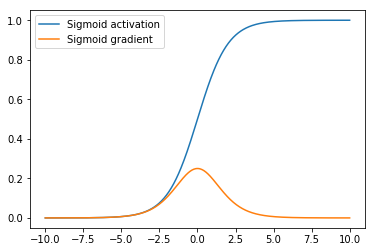

In [2]:
visualize_activation(data, gluon.nn.Activation('sigmoid'), "Sigmoid")

The sigmoid activation has since fallen out of use as the preferred activation function in designing neural networks due to some of its properties, shown in the plot above, like not being zero-centered and inducing vanishing gradients, that leads to poor performance during neural network training. Vanishing gradients here refers to the tendency of the gradient of the sigmoid function to be nearly zero for most input values. 

### tanh
The tanh, or hyperbolic tangent, activation function is also an s shaped curve albeit one whose output values range from -1 to 1. It is defined by the mathematical equation:

$$ tanh(x) = \dfrac{e^x - e^{-x}}{e^x + e^{-x}}$$ 

tanh addresses the issues of not being zero centered associated with the sigmoid activation function but still retains the vanishing gradient problems due to the gradient being asymptotically zero for values outside a narrow range of inputs. 

In fact, the tanh can be rewritten as,

$$tanh(x) = \dfrac{e^{2x} - 1}{e^{2x} + 1}$$

which shows it's direct relation to sigmoid by the following equation:



$$ tanh(x) = 2\sigma(2x) - 1$$

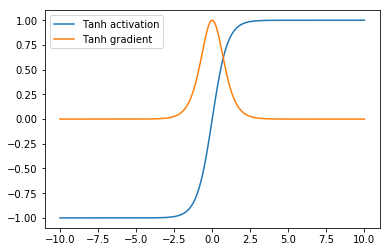

In [3]:
visualize_activation(data, gluon.nn.Activation('tanh'), "Tanh")

The use of tanh as activation functions in place of the logistic function was popularized by the success of the [LeNet architecture](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) and the [methods paper](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf) by LeCun et al

### SoftSign

The softsign activation is an alternative to tanh that is also centered at zero but converges asymptotically to -1 and 1 polynomially instead of exponentially. This means that the softsign activation does not saturate as quickly as tanh. As such, there are a greater range of input values for which the softsign assigns an output of strictly between -1 and 1.

$$ softsign(x) = \dfrac{x}{abs(x) + 1} $$

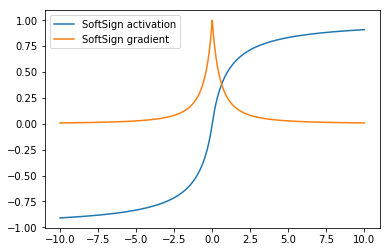

In [4]:
visualize_activation(data, gluon.nn.Activation('softsign'), "SoftSign")

The softsign function is not a commonly used activation with most neural networks and still suffers from the vanishing gradient problem as seen in the graph above.

## Rectifiers

### ReLU
ReLU, or Rectified Linear Unit is the most common activation function in convolutional neural networks and introduces a simple nonlinearity. When the value of the input into ReLU is positive, then it retains the same value. When the value is negative then it becomes zero. In equation form, the ReLU function is given as:

$$ ReLU(x) = \mathtt{max}(0, x) $$

ReLU was introduced to neural networks in the [paper by Hahnloser et al](https://papers.nips.cc/paper/1793-permitted-and-forbidden-sets-in-symmetric-threshold-linear-networks.pdf) and gained widespread popularity after it was shown in the [paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) by Alex Krizhevsky et al to perform much better than sigmoid and tanh. This paper also introduced the AlexNet CNN that won the ILSVRC challenge in 2012.

ReLU is the most widely used activation due to it's simplicity and performance across multiple datasets and although there have been efforts to introduce activation functions, many of them described in this tutorial, that improve on ReLU, they have not gained as much widespread adoption


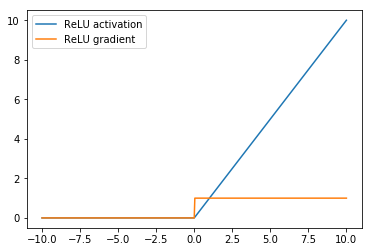

In [5]:
visualize_activation(data, gluon.nn.Activation('relu'), "ReLU")

As shown above, the ReLU activation mitigates the vanishing gradient problem associated with the sigmoid family of activations, by having a larger (infinite) range of values where it's gradient is non-zero. However, one drawback of ReLU as an activation function is a phenomenon referred to as the 'Dying ReLU', where gradient-based parameter updates can happen in such a way that the gradient flowing through a ReLU unit is always zero and the connection is never activated. This can largely be addressed by ensuring that the tuning the learning rate to ensure that it's not set too large when training ReLU networks.

### SoftReLU

SoftReLU also known as SmoothReLU or SoftPlus is a nonlinear activation function that takes the form

$$ SoftReLU(x) = log(1 + e^x)$$

The SoftReLU can be seen as a smooth version of the ReLU by observing that it's derivative is the sigmoid, seen below, which is a smooth version of the gradient of the ReLU shown above.

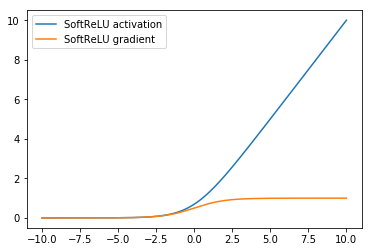

In [6]:
visualize_activation(data, gluon.nn.Activation('softrelu'), "SoftReLU")

### Leaky ReLU

Leaky ReLUs are a variant of ReLU that multiply the input by a small positive parameter $\alpha$ when the value is negative. Unlike the ReLU which sets the activation and gradient for negative values to zero, the LeakyReLU allows a small gradient. The equation for the LeakyReLU is:

$$ LeakyReLU(\alpha, x) = \begin{cases}
    x,& \text{if } x\geq 0\\
    \alpha x,              & \text{otherwise}
\end{cases}$$ 

where $\alpha > 0$ is small positive number. In MXNet, by default the $\alpha$ parameter is set to 0.01.

Here is a visualization for the LeakyReLU with $\alpha = 0.05$

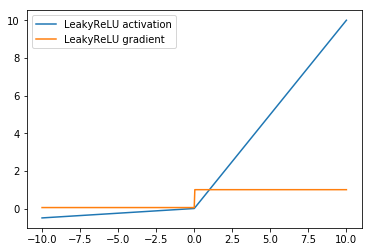

In [7]:
visualize_activation(data, gluon.nn.LeakyReLU(0.05), "LeakyReLU")

As shown in the graph, the LeakyReLU's gradient is non-zero everywhere, in an attempt to address the ReLU's gradient being zero for all negative values.

### PReLU
The PReLU activation function, or Parametric Leaky ReLU introduced by [He et al](https://arxiv.org/pdf/1502.01852.pdf), is a version of LeakyReLU that learns the parameter $\alpha$ during training. An initialization parameter is passed into the PreLU activation layer and this is treated as a learnable parameter that is updated via gradient descent during training. This is in contrast to LeakyReLU where $\alpha$ is a hyperparameter.

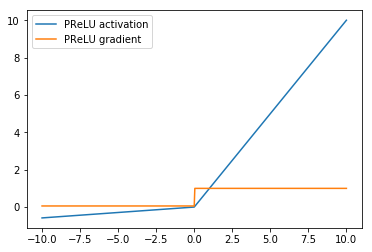

In [8]:
prelu = gluon.nn.PReLU(mxnet.init.Normal(0.05))
prelu.initialize()
visualize_activation(data, prelu, "PReLU")

The activation function and activation gradient of PReLU have the same shape as LeakyRELU

### ELU

The ELU or exponential linear unit introduced by [Clevert et al](https://arxiv.org/abs/1511.07289) also addresses the vanishing gradient problem like ReLU and it's variants but unlike the ReLU family, ELU allows negative values which may allows them to push mean unit activations closer to zero like batch normalization. 

The ELU function has the form

$$ ELU(\alpha, x) = \begin{cases}
    x,& \text{if } x\geq 0\\
    \alpha (e^x - 1),              & \text{otherwise}
\end{cases}$$

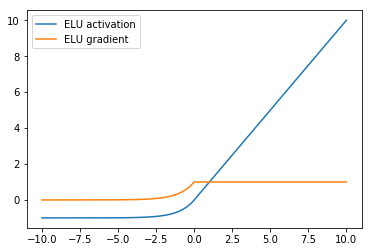

In [9]:
visualize_activation(data, gluon.nn.ELU(), "ELU")

### SELU
SELU stands for Scaled Exponential Linear Unit and was introduced by [Klambuer et al](https://arxiv.org/abs/1706.02515) and is a modification of the ELU that improves the normalization of it's outputs towards a zero mean and unit variance.

The SELU function has the form

$$ SELU(\alpha, x) = \lambda \cdot\begin{cases}
    x,& \text{if } x\geq 0\\
    \alpha (e^x - 1),              & \text{otherwise}
\end{cases}$$

In SELU, unlike ELU, the parameters $\alpha$ and $\lambda$ are fixed parameters calculated from the data. For standard scaled inputs, these values are $$\alpha=1.6732, \lambda=1.0507$$ as calculated in the paper.

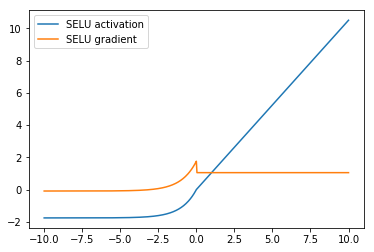

In [10]:
visualize_activation(data, gluon.nn.SELU(), "SELU")

### Swish
Swish is an activation function that attempts to address the shortcomings of ReLU by combining ideas from ReLU and sigmoid. Swish was discovered by searching the space of activation functions using a combination of exhaustive and reinforcement learning-based search and was introduced in the paper by [Ramchandran et al](https://arxiv.org/pdf/1710.05941.pdf)

The swish function is given as 

$$ swish(x) = x\cdot\sigma(\beta x)$$

where $\sigma$ is the sigmoid activation function $\sigma(x) = \frac{1}{1 + e^{-x}}$ described above and $\beta$ is a hyperparameter set to 1 by default in MXNet.

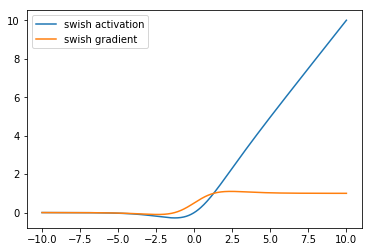

In [11]:
visualize_activation(data, gluon.nn.Swish(), "swish")